# MNIST handwritten digits

Classifying handwritten digits using a neural network in pytorch.

Following the pytorch tutorials at https://pytorch.org/tutorials/beginner/basics/intro.html.

## Getting the data

In [1]:
# Packages and modules
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Functions and classes
from torchvision.transforms import ToTensor, Lambda
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [2]:
# Download and/or load dataset (thanks Yann), and transform to tensors, and one-hot encodings
target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
train = MNIST(root="data", transform=ToTensor(), target_transform=target_transform, download=True)
test = MNIST(root="data", transform=ToTensor(), target_transform=target_transform, download=True)

# Make dataloaders
train_dataloader = DataLoader(train, batch_size=64)
test_dataloader = DataLoader(test, batch_size=64)

# Enumerate training dataloader
examples = enumerate(train_dataloader)

# Get first batch of samples and check shape
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 10])


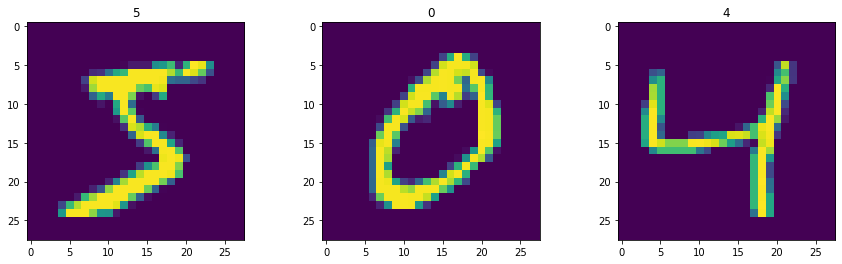

In [3]:
# Show first few inputs and labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
for i in range(3):
    ax = [ax1, ax2, ax3][i]
    ax.imshow(example_data[i][0])
    ax.set_title(f"{example_targets[i].argmax(0)}")
plt.show()

## Feedforward neural network

In [39]:
# Breakdown modelling functions
X = torch.rand(1, 28, 28)
print(f"Input: {X.shape}")
X_flat = nn.Flatten()(X)
print(f"Flattened: {X_flat.shape}")
X_l = nn.Linear(28*28, 4)(X_flat)
print(f"Linear: {X_l}")
X_r = nn.ReLU()(X_l)
print(f"ReLU: {X_r}")
logits = nn.Linear(4, 4)(X_r)
print(f"Model: {logits}")
pred_probab = nn.Softmax(dim=1)(logits)
print(f"Probabilities: {pred_probab}")
print(f"Predicted class: {pred_probab.argmax(1)}")

Input: torch.Size([1, 28, 28])
Flattened: torch.Size([1, 784])
Linear: tensor([[-0.2457, -0.1441, -0.1078,  0.2326]], grad_fn=<AddmmBackward0>)
ReLU: tensor([[0.0000, 0.0000, 0.0000, 0.2326]], grad_fn=<ReluBackward0>)
Model: tensor([[ 0.2443,  0.4510,  0.1096, -0.0489]], grad_fn=<AddmmBackward0>)
Probabilities: tensor([[0.2598, 0.3194, 0.2270, 0.1938]], grad_fn=<SoftmaxBackward0>)
Predicted class: tensor([1])


In [40]:
# Create a neural network
ff_seq = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 10),
)
ff_seq(X)

tensor([[ 0.0478,  0.0041,  0.0234, -0.0700, -0.0953,  0.0914,  0.0948, -0.0567,
          0.1128,  0.1416]], grad_fn=<AddmmBackward0>)

In [41]:
# Create neural network model class
class NeuralNetwork(nn.Module):
    def __init__(self, seq_modules):
        super(NeuralNetwork, self).__init__()
        self.seq_modules = seq_modules

    def forward(self, x):
        logits = self.seq_modules(x)
        return logits

In [42]:
# Create neural network model
ff_model = NeuralNetwork(ff_seq)
print(ff_model)

NeuralNetwork(
  (seq_modules): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [43]:
name, param = next(ff_model.named_parameters())
print(f"Layer: {name}")
print(f"Size: {param.size()}")
print(f"Values : {param[:2]} \n")

Layer: seq_modules.1.weight
Size: torch.Size([512, 784])
Values : tensor([[ 1.0193e-03,  2.9743e-02,  6.9053e-03,  ..., -2.6484e-02,
          2.1244e-02, -9.8113e-05],
        [-4.2283e-03,  2.0192e-02, -2.0636e-02,  ...,  2.3132e-02,
         -2.2456e-02,  1.5960e-02]], grad_fn=<SliceBackward0>) 



In [44]:
# Use model to get predictions
ff_model(X)

tensor([[ 0.0478,  0.0041,  0.0234, -0.0700, -0.0953,  0.0914,  0.0948, -0.0567,
          0.1128,  0.1416]], grad_fn=<AddmmBackward0>)

## Move model to GPU

In [45]:
# Set device to GPU or CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [46]:
# Create neural network model
ff_model = ff_model.to(device)

In [47]:
# Use model to get predictions on GPU
X = torch.rand(1, 28, 28, device=device)
print(f"Model: {ff_model(X)}")

Model: tensor([[ 0.0795, -0.0484,  0.0224, -0.0457, -0.0652,  0.0321,  0.0637, -0.0574,
          0.1391,  0.1909]], device='cuda:0', grad_fn=<AddmmBackward0>)


## Define training/validation functions

In [48]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            y = y.to(device)
            pred = model(X.to(device))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return correct

## Train model

In [49]:
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ff_model.parameters(), lr=learning_rate)

In [50]:
last_correct = 0
for t in range(10):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, ff_model, loss_fn, optimizer)
    correct = test_loop(test_dataloader, ff_model, loss_fn)
    if correct - last_correct < 0.01:
        break
    else:
        last_correct = correct
print("Done!")

Epoch 1
-------------------------------
loss: 2.298903  [    0/60000]
loss: 2.297168  [ 6400/60000]
loss: 2.292222  [12800/60000]
loss: 2.276720  [19200/60000]
loss: 2.277781  [25600/60000]
loss: 2.275098  [32000/60000]
loss: 2.268406  [38400/60000]
loss: 2.271690  [44800/60000]
loss: 2.255951  [51200/60000]
loss: 2.244268  [57600/60000]
Test Error: 
 Accuracy: 38.1%, Avg loss: 2.249767 

Epoch 2
-------------------------------
loss: 2.244042  [    0/60000]
loss: 2.238919  [ 6400/60000]
loss: 2.248145  [12800/60000]
loss: 2.206284  [19200/60000]
loss: 2.223179  [25600/60000]
loss: 2.220074  [32000/60000]
loss: 2.196941  [38400/60000]
loss: 2.220773  [44800/60000]
loss: 2.185590  [51200/60000]
loss: 2.162479  [57600/60000]
Test Error: 
 Accuracy: 54.0%, Avg loss: 2.175430 

Epoch 3
-------------------------------
loss: 2.165941  [    0/60000]
loss: 2.153985  [ 6400/60000]
loss: 2.180377  [12800/60000]
loss: 2.099205  [19200/60000]
loss: 2.137998  [25600/60000]
loss: 2.131625  [32000/600

KeyboardInterrupt: 

## Save/load model

In [ ]:
torch.save(model, 'models/ff_mnist')

In [ ]:
model = torch.load('models/ff_mnist')

## Check predictions

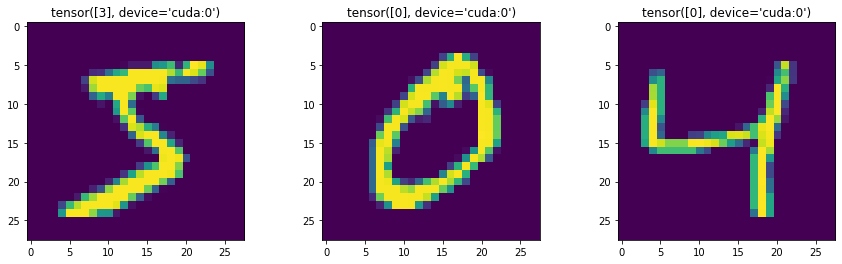

In [19]:
# Show first few sample inputs and predictions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
for i in range(3):
    ax = [ax1, ax2, ax3][i]
    ax.imshow(example_data[i][0])
    ax.set_title(f"{ff_model(example_data[i].to(device)).argmax(1)}")
plt.show()

## Convolutional neural network

In [20]:
X = torch.rand(1, 1, 28, 28)

In [27]:
# Create a neural network
conv_seq = nn.Sequential(
    nn.Conv2d(1, 5, 5),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(5*24*24, 32),
    nn.ReLU(),
    nn.Linear(32, 10),
)
conv_seq(X)

tensor([[-0.0082,  0.0921, -0.1635, -0.1004,  0.1426,  0.0284, -0.1454, -0.1945,
          0.1260,  0.1891]], grad_fn=<AddmmBackward0>)

In [28]:
# Create neural network model
conv_model = NeuralNetwork(conv_seq).to(device)
print(conv_model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=2880, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [30]:
# Use model to get predictions
conv_model(X.to(device))

tensor([[-0.0082,  0.0921, -0.1635, -0.1004,  0.1426,  0.0284, -0.1454, -0.1945,
          0.1260,  0.1891]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [31]:
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_model.parameters(), lr=learning_rate)

In [33]:
last_correct = 0
for t in range(10):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, conv_model, loss_fn, optimizer)
    correct = test_loop(test_dataloader, conv_model, loss_fn)
    if correct - last_correct < 0.01:
        break
    else:
        last_correct = correct
print("Done!")

Epoch 1
-------------------------------
loss: 1.873989  [    0/60000]
loss: 1.673955  [ 6400/60000]
loss: 1.683701  [12800/60000]
loss: 1.427447  [19200/60000]
loss: 1.382346  [25600/60000]
loss: 1.242085  [32000/60000]
loss: 1.059656  [38400/60000]
loss: 1.176145  [44800/60000]
loss: 0.945284  [51200/60000]
loss: 0.848434  [57600/60000]
Test Error: 
 Accuracy: 81.8%, Avg loss: 0.821153 

Epoch 2
-------------------------------
loss: 0.896722  [    0/60000]
loss: 0.645473  [ 6400/60000]
loss: 0.743575  [12800/60000]
loss: 0.624107  [19200/60000]
loss: 0.612872  [25600/60000]
loss: 0.583204  [32000/60000]
loss: 0.507099  [38400/60000]
loss: 0.681044  [44800/60000]
loss: 0.582747  [51200/60000]
loss: 0.545725  [57600/60000]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.517669 

Epoch 3
-------------------------------
loss: 0.579410  [    0/60000]
loss: 0.418876  [ 6400/60000]
loss: 0.459973  [12800/60000]
loss: 0.470456  [19200/60000]
loss: 0.442511  [25600/60000]
loss: 0.442578  [32000/600